In [6]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch

import renyi
import utils
import sxp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$\newcommand{\X}{\mathcal{X}}$
$\newcommand{\k}{\kappa}$
$\newcommand{\D}{D^K_{\alpha}}$
$\newcommand{\H}{H^K_{\alpha}}$

## Similarity-sensitive entropy

Let $\mathcal{X}$ be a finite set of size $n$ and let $\k$ be a positive definite kernel. Let $X$ be a random variable with distribution $p$ on $\X$. Let $K$ be the Gram matrix induced by $\k$ on $\X$.

We define the similarity-sensitive Renyi entropy of order alpha [cite Tom Leinster] of $X$ by:

$$\H(p) = \frac{1}{1-\alpha} \log \sum_{i = 1}^n  p_i (Kp)_i^{\alpha-1}$$

Special Case: If we have a metric space $(\X, d)$, we can define $\k(x, y) \triangleq \exp(-d(x, y))$. [Reams]

In [65]:
n, r = 2, 1
K = np.array([[1, np.exp(-r)], [np.exp(-r), 1]])
K = utils.from_numpy(K)

# p = np.random.dirichlet(n*[1], 1)
# p = utils.from_numpy(p, False)

q = np.random.dirichlet(n*[5], 1)
q = utils.from_numpy(q, False)

H = renyi.sim_entropy(K, q, True)

# def opt_q(p, K):
#     theta = p[0, 0]
#     print(theta)
#     emr = K[0, 1]
#     phi = theta - emr / (1 - emr)
#     return np.array([[phi, 1-phi]])

# pstar = sxp.one_simplex_project(torch.tensor(opt_q(q.data.numpy(), K.numpy())))
# torch.tensor(opt_q(q.data.numpy(), K.numpy()))

In [8]:
print('Target', q)

p_free = torch.nn.Parameter(0*q.clone())
temp = torch.nn.Parameter(torch.tensor(1.).double())

p_optimizer = torch.optim.Adam([p_free, temp], lr=0.1, amsgrad=True)
optims = [p_optimizer]

proj_op = lambda p_free, temp: torch.softmax(p_free / torch.exp(temp), dim=1)
#proj_op = lambda p_free, temp: sxp.simplex_project(p_free)

orig_p = proj_op(p_free, temp)

for _ in range(1000):
    
    [_.zero_grad() for _ in optims]
    
    p = proj_op(p_free, temp)
    loss = renyi.sim_cross_entropy(K, q, p, 1, True)
    
    if _ % 100 == 0:
        print("%d - %.5f" % (_, loss.item()))

    loss.backward()
    [_.step() for _ in optims]

final_p = proj_op(p_free, temp)
final_p

Target tensor([[0.7214, 0.2786]], dtype=torch.float64)
0 - 0.69315
100 - 0.59187
200 - 0.59187
300 - 0.59187
400 - 0.59187
500 - 0.59187
600 - 0.59187
700 - 0.59187
800 - 0.59187
900 - 0.59187


tensor([[9.9998e-01, 1.7860e-05]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [9]:
H, renyi.sim_cross_entropy(K, q, final_p) 

(tensor([[0.3094]], dtype=torch.float64),
 tensor([[0.2786]], dtype=torch.float64, grad_fn=<TransposeBackward0>))

### MaxEnt is alpha-independent

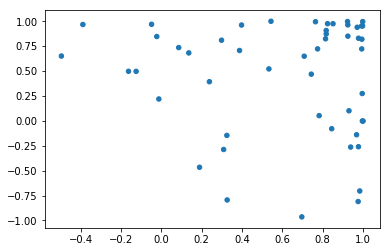

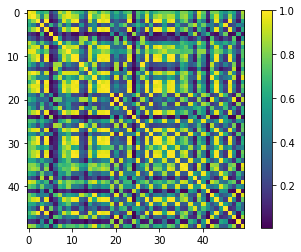

In [10]:
d, n = 2, 50
Y = torch.tensor(np.cos(1*np.random.multivariate_normal(np.zeros(d), np.eye(d), n)))
#Y = Y / torch.norm(Y, dim=1, keepdim=True)
plt.scatter(Y[:, 0], Y[:, 1], s=n*[1000/n])
plt.show()

kernel = lambda x, y: renyi.generic_kernel(x, y, lambda W: renyi.rbf_kernel(W, [1]))
#kernel = lambda x, y: renyi.generic_kernel(x, y, lambda W: renyi.poly_kernel(W, degree=3, p=3))
K = kernel(Y, Y)[:n, :n]
plt.imshow(K)
plt.colorbar()

In [11]:
#p_free = torch.nn.Parameter(torch.tensor(1+0.*np.random.rand(1, n)))
# For projected gradient initialize with a sparse solution on simplex
p_free = torch.nn.Parameter(torch.tensor(0*np.random.dirichlet(n*[1], 1)))
temp = torch.nn.Parameter(torch.tensor(1.).double())

p_optimizer = torch.optim.Adam([p_free, temp], lr=0.01, amsgrad=True)
optims = [p_optimizer]

proj_op = lambda p_free, temp: torch.softmax(p_free / torch.exp(temp), dim=1)
proj_op = lambda p_free, temp: sxp.simplex_project(p_free)

0 - 0.70568
100 - 1.07466
200 - 1.07571
300 - 1.07572
400 - 1.07572
500 - 1.07572
600 - 1.07572
700 - 1.07572
800 - 1.07572
900 - 1.07572


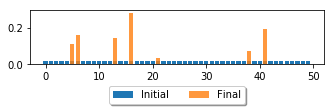

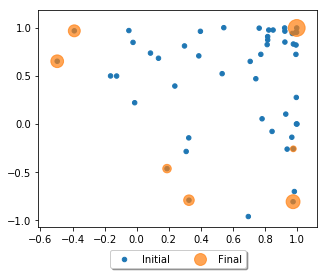

In [12]:
orig_p = proj_op(p_free, temp).data.numpy().squeeze()

for _ in range(1000):
    
    [_.zero_grad() for _ in optims]
    
    p = proj_op(p_free, temp)
    loss = - renyi.sim_entropy(K, p, 1)
    
    if _ % 100 == 0:
        print("%d - %.5f" % (_, -loss.item()))

    loss.backward()
    [_.step() for _ in optims]

final_p = proj_op(p_free, temp).data.numpy().squeeze()

plt.figure(figsize=(5.26, 1))
plt.bar(range(n), orig_p, label='Initial')
plt.bar(range(n), final_p, alpha=0.8, label='Final')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=2)
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(Y[:, 0], Y[:, 1], s=1000*orig_p, label='Initial')
plt.scatter(Y[:, 0], Y[:, 1], s=1000*final_p, alpha=0.7, label='Final')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=True, ncol=2)
plt.show()

## Performance test for entropy and divergence implementation

Can compute $H^K_{\alpha}(p)$ and $D^K_{\alpha}(p, q)$ :
  * $n= 1000$, $M = 100$ - H 4 ms D 13 ms
  * $n= 2000$, $M = 100$ - H 13 ms D 40 ms
  * $n= 10000$, $M = 100$ - H 263 ms D 865 ms
  * $n= 15000$, $M = 100$ - H 729 ms D 1760 ms
  
$M$ is batch size. No significative variation in time when changing the order $\alpha$.

Wall time: 0 ns
Wall time: 1e+03 µs
Wall time: 1.88 ms
Wall time: 1.99 ms


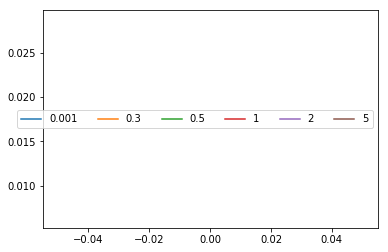

In [298]:
n, M = 100, 1

%time K = 0.01*np.random.rand(n, n)
%time K = (K * K.T) + 0.7 * np.eye(n)
K = utils.from_numpy(K)

#print('Min Eigenvalue of K: ', torch.eig(K)[0].min(dim=0)[0][0].item())

p = np.random.dirichlet(n*[1], M)
p = utils.from_numpy(p, True)

q = np.random.dirichlet(n*[1], M)
q = utils.from_numpy(q, True)

%time H = renyi.sim_entropy(K, p)
%time D = renyi.sim_divergence(K, p, q)

for alpha in [0.001, 0.3, 0.5, 1, 2, 5]:
    W = renyi.mink_sim_divergence(K, p, q, alpha)
    #W = renyi.sim_entropy(K, p, alpha)
    plt.plot(W.data.numpy(), label=str(alpha));
plt.legend(ncol=6, loc='best')

In [299]:
#p_free = torch.nn.Parameter(torch.tensor(1+0.*np.random.rand(1, n)))
# For projected gradient initialize with a sparse solution on simplex
p_free = torch.nn.Parameter(torch.tensor(0*np.random.dirichlet(n*[1], 1)))
temp = torch.nn.Parameter(torch.tensor(1.).double())

p_optimizer = torch.optim.Adam([p_free, temp], lr=0.05, amsgrad=True)
optims = [p_optimizer]

proj_op = lambda p_free, temp: torch.softmax(p_free / torch.exp(temp), dim=1)
#proj_op = lambda p_free, temp: sxp.simplex_project(p_free)

In [300]:
orig_p = proj_op(p_free, temp)

for _ in range(1000):
    
    [_.zero_grad() for _ in optims]
    
    p = proj_op(p_free, temp)
    loss = renyi.mink_sim_divergence(K, q, p, alpha=1, use_inv=False)
    
    if _ % 100 == 0:
        print("%d: %.3e - TV: %.3e" % (_, loss.item(), torch.abs(p - q).max().item()))

    loss.backward()
    [_.step() for _ in optims]

final_p = proj_op(p_free, temp).data.numpy().squeeze()

0: 8.403e-03 - TV: 3.876e-02
100: 1.748e-04 - TV: 1.042e-03
200: 1.254e-04 - TV: 8.388e-04
300: 6.959e-05 - TV: 5.644e-04
400: 1.057e-04 - TV: 8.392e-04
500: 6.528e-05 - TV: 3.885e-04
600: 6.182e-05 - TV: 4.390e-04
700: 8.410e-05 - TV: 4.180e-04
800: 9.692e-05 - TV: 8.660e-04
900: 5.346e-05 - TV: 3.670e-04


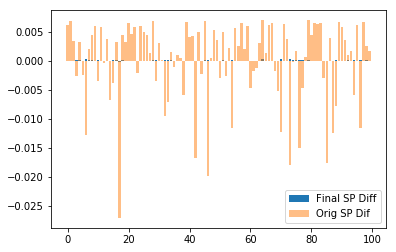

In [301]:
plt.bar(range(n), (K @ p.transpose(0, 1) - K @ q.transpose(0, 1)).data.numpy().squeeze(), label='Final SP Diff')
plt.bar(range(n), (K @ orig_p.transpose(0, 1) - K @ q.transpose(0, 1)).data.numpy().squeeze(), alpha=0.5, label='Orig SP Dif')
plt.legend()

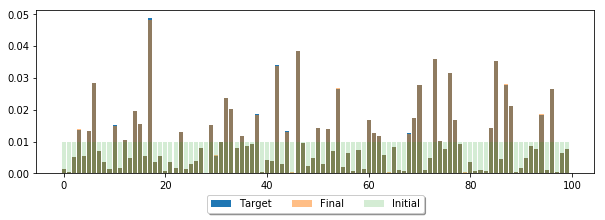

In [302]:
plt.figure(figsize=(10, 3))
plt.bar(range(n), q.data.numpy().squeeze(), label='Target')
plt.bar(range(n), final_p, alpha=0.5, label='Final')
plt.bar(range(n), orig_p.data.numpy().squeeze(), alpha=0.2, label='Initial')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3)
plt.show()

## Similarity-sensitive divergence between two empirical distributions on a metric space

Let $(\X, \k)$ be a space endowed with a positive definite kernel. Consider two probability measures $\mu$ and $\nu$ defined on $\X$. Note that if an arbitrary $x \in \X$ has measure zero under both $\mu$ and $\nu$, then such $x$ is irrelevant in the computation of $\D(p || q)$.

Suppose $\mu$ and $\nu$ are empirical distributions of the form $\mu = \sum_{i = 1}^n a_i \delta_{x_i}$ and $\nu = \sum_{j = 1}^m b_i \delta_{y_i}$. Define the sequences $X = [x_1, \ldots, x_n ]$ and $Y = [y_1, \ldots, y_m]$. According to the remark above, we can restrict our attention to the sequence $Z = [X, Y] \triangleq [x_1, \ldots, x_n, y_1, \ldots, y_m ]$. The Gram matrix of $\k$ on $Z$ is a block matrix of the form: 

$$K \triangleq \begin{pmatrix} K_{xx} & K_{xy} \\  K_{yx} & K_{yy}  \end{pmatrix},$$

where $K_{xy}$ and $K_{yx}$ are possibly rectangular (and given $\k$ is p.d., $K_{xy} = K^T_{yx}$).

Define $\tilde{\mu}$ to be the natural extension of the vector representation of $\mu$ from $X$ to $Z$, i.e., $\tilde{\mu} = [\mu, 0]$. Analogously,  $\tilde{\nu} = [0, \nu]$. Let $\rho = \frac{\tilde{\mu} + \tilde{\nu}}{2}$.

$$\begin{eqnarray*} 
\D(\tilde{\mu}, \tilde{\nu}) &=& \frac{1}{\alpha - 1} \left[ \log \sum_{z \in Z} \tilde{\mu}_z \left( \frac{(K\tilde{\mu})_z}{(K\rho)_z}\right)^{\alpha-1} + \log \sum_{z \in Z} \tilde{\nu}_z \left( \frac{(K\tilde{\nu})_z}{(K\rho)_z}\right)^{\alpha-1} \right] \\ 
&=& \frac{1}{\alpha - 1} \left[ \log \sum_{x \in X} \mu_x \left( \frac{(K_{xx}\mu)_x}{\frac{1}{2}\left(K_{xx}\mu + K_{xy}\nu\right)_x}\right)^{\alpha-1} + \log \sum_{y \in Y} \nu_y \left( \frac{(K_{yy}\nu)_y}{\frac{1}{2}\left(K_{yy}\nu + K_{yx}\mu\right)_y}\right)^{\alpha-1} \right] \\
&=& \frac{1}{\alpha - 1} \left[ \log \left[ \mu^T \left( \frac{2 K_{xx}\mu}{K_{xx}\mu + K_{xy}\nu}\right)^{\alpha-1}\right] + \log \left[ \nu^T \left( \frac{2 K_{yy}\nu}{K_{yy}\nu + K_{yx}\mu}\right)^{\alpha-1} \right] \right] 
\end{eqnarray*}$$

The computation of $K$ requires $\mathcal{O}(|\k|(m+n)^2)$ operations, where $|\k|$ represents the cost of a kernel evaluation. The computation of the divergence (given $K$) is of in order of  $\mathcal{O}((n+m)^2)$ operations.

*Note:* We can do projected gradient descent on this objective using the sxp file. This gives sparse solutions on $\mu$, while the logit-softmax (with temperature) parametrization gives dense solutions. When $m >> n$, softmax is advisable, while projected gradient is to be preferred when $n >> m$


In [62]:
alpha = 2

m, d = 500, 2

nu = np.random.dirichlet(m*[m], 1)
nu = -np.sort(-nu, axis=1)
nu = torch.tensor(nu)
Y = torch.tensor(np.random.multivariate_normal(np.zeros(d), np.eye(d), m))

n = 50

#mu_free = torch.nn.Parameter(torch.tensor(1+0.*np.random.rand(1, n)))
# For projected gradient initialize with a sparse solution on simplex
mu_free = torch.nn.Parameter(torch.tensor(np.random.dirichlet(n*[1], 1)))
temp = torch.nn.Parameter(torch.tensor(1.).double())

X = torch.nn.Parameter(torch.tensor(np.random.multivariate_normal(np.zeros(d), 1.1*np.eye(d), n)))


mu_optimizer = torch.optim.Adam([mu_free, temp], lr=0.005, amsgrad=True)
x_optimizer = torch.optim.Adam([X], lr=0.2, amsgrad=True)
optims = [mu_optimizer, x_optimizer]

kernel = lambda x, y: renyi.generic_kernel(x, y, renyi.rbf_kernel)

In [63]:
for _ in range(250):
    
    [_.zero_grad() for _ in optims]
    
    #mu = torch.softmax(mu_free / torch.exp(temp), dim=1)
    mu = sxp.simplex_project(mu_free)
    loss, K = renyi.mixture_divergence(mu, X, nu, Y, alpha, kernel)
    
    if _ % 75 == 0:
        print("%d - %.4f" % (_, loss.item()))
        
#     if _ % 75 == 0:    
#         W = torch.cat((X, Y))
#         D = torch.norm(W[..., None, :] - W[..., None, :, :], p=2, dim=-1) 
    
#         fig, ax1 = plt.subplots(figsize=(4, 2))
#         ax1.plot(D[-m:, :n].min(dim=1)[0].data.numpy(), 'b.')
#         ax1.twinx().plot(nu[0, :].data.numpy(), 'r.')
#         fig.tight_layout()
#         plt.show()
        
#         plt.figure(figsize=(4, 4))
#         plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
#         plt.scatter(X.data.numpy()[:, 0], X.data.numpy()[:, 1], s=list(1000*mu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
#         plt.legend(loc='best');
#         plt.show()

    loss.backward()
    [_.step() for _ in optims]
    
mu = sxp.simplex_project(mu_free) 
#mu = torch.softmax(mu_free / torch.exp(temp), dim=1)
    
plt.figure(figsize=(4, 4))
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(X.data.numpy()[:, 0], X.data.numpy()[:, 1], s=list(1000*mu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

print('Sparsity of solution: %.1f%% (%d/%d)' % (100 * (1 - torch.sum(mu > 0).item() / n), torch.sum(mu > 0).item(), n))

0 - 0.6133
75 - 0.0010


KeyboardInterrupt: 

### Convergence rate of empirical estimator

In [414]:

N, d = 10, 2

p = torch.tensor(np.random.dirichlet(N*[N], 1))
Y = torch.rand(N, d).double()

q = torch.tensor(np.random.dirichlet(N*[N], 1))
X = torch.rand(N, d).double()



tensor([0.1398], dtype=torch.float64)

1 2
10 2
100 2
250 2
500 2
1 5
10 5
100 5
250 5
500 5
1 10
10 10
100 10
250 10
500 10


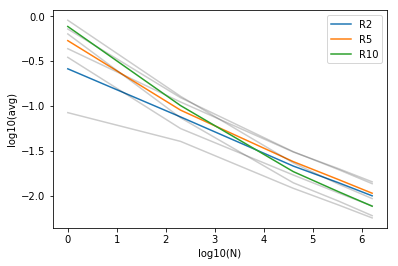

In [428]:
alpha = 2

kernel = lambda x, y: renyi.generic_kernel(x, y, lambda u, v: renyi.rbf_kernel(u, v, p=2), full=False)

Ns = [1, 10, 100, 250, 500]

for d in [2, 5, 10]:
    res = []
    for N in Ns:
        print(N, d)
        n_res = []

        for trial in range(1000):
            p = torch.tensor(np.random.dirichlet(N*[N], 1))
            Y = torch.rand(N, d).double()

            q = torch.tensor(np.random.dirichlet(N*[N], 1))
            X = torch.rand(N, d).double()

            
            loss = mink_mixture_divergence(p, Y, q, X, kernel, alpha, use_inv=False)
            
            n_res.append(loss.item())
        res.append(n_res)

    avgs = [np.mean(_) for _ in res]
    stds = [np.std(_) for _ in res]
    avgup = [avgs[i] + stds[i] for i in range(len(avgs))]
    avgdw = [avgs[i] - stds[i] for i in range(len(avgs))]

    plt.plot(np.log(Ns), np.log10(avgs), label='R'+str(d))
    plt.plot(np.log(Ns), np.log10(avgup), c='k', alpha=0.2)
    plt.plot(np.log(Ns), np.log10(avgdw), c='k', alpha=0.2)
    #plt.plot(np.log(Ns), np.log10(stds), label='S'+str(d))

plt.xlabel('log10(N)')
plt.ylabel('log10(avg)')
plt.legend()

In [214]:
avgs = [np.mean(_) for _ in res]

In [212]:
avgs, stds

([0.9857256569052996, 0.2976379661834612, 0.06802768596127225],
 [0.21088952950819773, 0.0581927112818554, 0.013146011912508311])

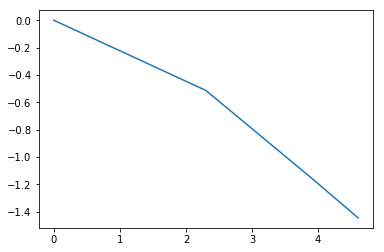

In [185]:
plt.plot(np.log(Ns), np.log10(avgs))

### Centroid of Random Ellipses

In [6]:
from skimage.transform import resize

In [629]:
N = 500
A = np.array([(i/(N-1), 1-j/(N-1)) for i in range(N) for j in range(N)])

n = 100
E = []
for _ in range(100):
    # L1 and L2 act as radii in their correspondig directions
    # Theta tells angle in clockwise orientation
    c = np.array([0.1 + 0.8*np.random.rand(), 0.1 + 0.8*np.random.rand()])
    w0, w1 = np.min([c[0], 1-c[0]]), np.min([c[1], 1-c[1]]) 
    theta, L1, L2 = 2 * np.pi * np.random.rand(), (0.1 + 0.5*w0*np.random.rand()), (0.1 + 0.5*w1*np.random.rand())
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Linv = np.array([[1/L1, 0], [0, 1/L2]])
   

    v = (A - c) @ R.T @ Linv
    v1 = 1.*(np.abs(np.sum(v**2, axis=1) - 1) < 5e-2)

    theta, L1, L2 = 2 * np.pi * np.random.rand(), L1 * (0.4 + 0.1*np.random.rand()), L2 * (0.4 + 0.1*np.random.rand())
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Linv = np.array([[1/L1, 0], [0, 1/L2]])
    c = np.array([c[0] + 0.3*L1 * np.random.randn(), c[1]+ 0.3*L2 * np.random.randn()])

    v = (A - c) @ R.T @ Linv
    v2 = 1.*(np.abs(np.sum(v**2, axis=1) - 1) < 7e-2)
    v = v1 + v2
    v /= np.sum(v)
    v = v.reshape(N, N).T

#     plt.figure(figsize=(5, 5))
#     plt.imshow(v)

    resize_v = resize(v, (n, n), mode='constant', anti_aliasing=True)#, anti_aliasing_sigma=1)
    resize_v /= np.sum(resize_v)
#     plt.figure(figsize=(5,5))
#     plt.imshow(resize_v, cmap='binary');
#     plt.show()

    E.append(resize_v[None, ...])

E = np.concatenate(E, axis=0)
E = torch.tensor(E)

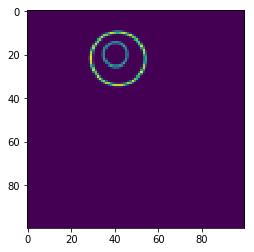

In [630]:
plt.imshow(E[15, ...])

### Were we doing the same kerneling?

In [ ]:
rbf_kernel(W, sigmas=[1.], p=2, d=2)

In [8]:
Z = torch.tensor(np.array(list(itertools.product(np.linspace(0, 1, 28), np.linspace(0, 1, 28))))).double()

In [32]:
K = renyi.rbf_kernel(torch.cat((Z, Z)),  [1], 2, 2).double()

In [33]:
im1 = torch.ones(28, 28)
im1 /= im1.sum()
im1 = im1.view(-1, 1).double()

im2 = torch.abs(torch.rand(28, 28))
im2 /= im2.sum()
im2 = im2.view(-1, 1).double()


In [34]:
im = torch.cat((im1, im2))

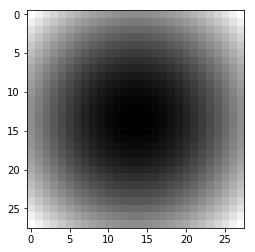

In [43]:
basic_cv = K[:28*28, :28*28] @ im1
basic_cv = basic_cv.view(28, 28)

plt.imshow(basic_cv, cmap='gray_r')

In [62]:
[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, 28), np.linspace(0, 1, 28))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**2)
Kmat = torch.tensor(Kmat)

kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)
Kmat.shape

torch.Size([28, 28])

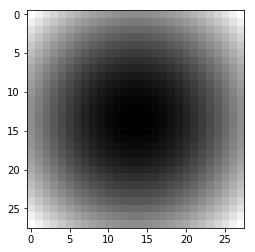

In [63]:
fancy_cv = kernel(im1.view(28, 28))
plt.imshow(fancy_cv, cmap='gray_r')


In [51]:
mu, nu = im1, im2
n = m = 28*28 

In [54]:
Kmu1 = K[:n, :n] @ mu
Knu1 = K[:n, -m:] @ nu

Knu2 = K[-m:, -m:] @ nu
Kmu2 = K[:-m, :n] @ mu

v = Kmu1 / torch.clamp_min(Knu1, 1e-10)
u = Knu2 / torch.clamp_min(Kmu2, 1e-10)


In [59]:
_Kmu1 = kernel(mu.view(28, 28))
_Knu1 = kernel(nu.view(28, 28))

_Knu2 = kernel(nu.view(28, 28))

In [60]:
torch.max(Kmu1.view(28, 28) - _Kmu1), torch.max(Knu1.view(28, 28) - _Knu1)

(tensor(4.4409e-16, dtype=torch.float64),
 tensor(4.4409e-16, dtype=torch.float64))

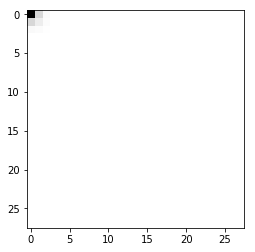

In [13]:
plt.imshow(K[0, :28*28].view(28, 28).data.numpy(), cmap='gray_r')

In [642]:
alpha = 1.5

#mu_free = torch.nn.Parameter(torch.tensor(1+0.*np.random.rand(1, n)))
# For projected gradient initialize with a sparse solution on simplex
mu_free = torch.nn.Parameter(torch.tensor(0*np.random.dirichlet(n*n*[1], 1)))
temp = torch.nn.Parameter(torch.tensor(1.).double())
mu_optimizer = torch.optim.Adam([mu_free, temp], lr=0.05, amsgrad=True)
optims = [mu_optimizer]

mu = sxp.simplex_project(mu_free).view(n, n)

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
Kmat = np.exp(-7*np.abs(Xgrid - Ygrid)**2)
Kmat = utils.from_numpy(Kmat)

kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)
Knu = torch.matmul(torch.matmul(Kmat, E), Kmat)

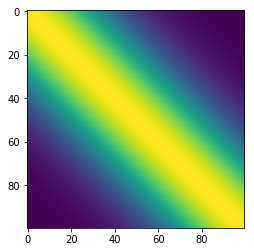

In [643]:
plt.imshow(Kmat)

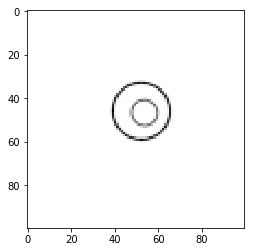

In [644]:
#plt.imshow(mu.data.numpy())
plt.imshow(E[ 2+0*np.random.choice(E.shape[0]), :].data.numpy(), cmap='gray_r')

0 - 40.5513


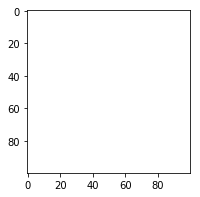

75 - 36.4829


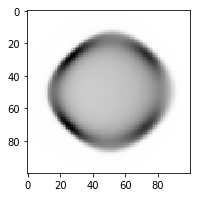

150 - 36.4758


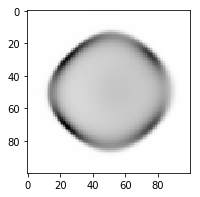

225 - 36.4671


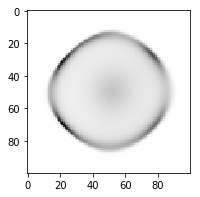

300 - 36.4610


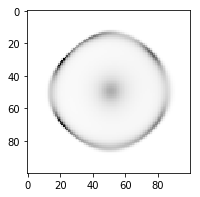

375 - 36.4576


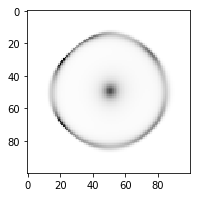

450 - 36.4560


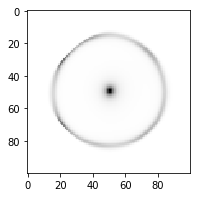

525 - 36.4550


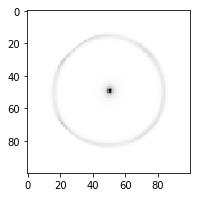

600 - 36.4546


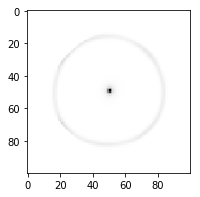

675 - 36.4542


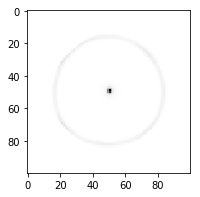

750 - 36.4555


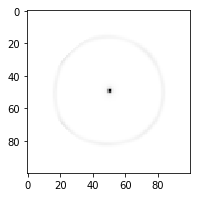

825 - 36.4534


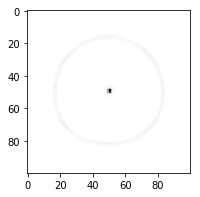

900 - 36.4533


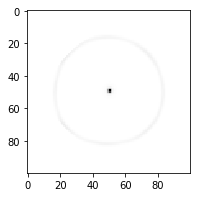

975 - 36.4553


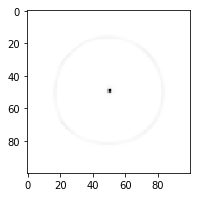

In [645]:
for _ in range(1000):
    
    [_.zero_grad() for _ in optims]
    
    mu = torch.softmax(mu_free / torch.exp(temp), dim=1).view(n, n)
    #mu = sxp.simplex_project(mu_free).view(n, n)
    ix = np.random.choice(E.shape[0], 30)
    loss = renyi.conv_divergence(mu, E[:, :], alpha, kernel).mean()
    
    if _ % 75 == 0:
        print("%d - %.4f" % (_, 100*loss.item()))
        #mu = sxp.simplex_project(mu_free).view(n, n)
        mu = torch.softmax(mu_free / torch.exp(temp), dim=1).view(n, n)
        plt.figure(figsize=(3, 3))
        plt.imshow(mu.data.numpy(), cmap='gray_r')
        plt.show()
        
    loss.backward()
    [_.step() for _ in optims]
    
#mu = sxp.simplex_project(mu_free).view(n, n)
mu = torch.softmax(mu_free / torch.exp(temp), dim=1).view(n, n)

http://people.csail.mit.edu/eddchien/papers/icml2018_barycenters.pdf

file:///C:/Users/jgall/Downloads/PRV18_barycenter.pdf

https://arxiv.org/abs/1705.07443

https://arxiv.org/abs/1705.07443